In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
apikey=os.getenv('CENSUS_API_KEY')
import requests
import textwrap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sns.set(style="darkgrid")
# Set figure width to 12 and height to 9
plt.rcParams["figure.figsize"] = [12,7]

/Users/aolsen/opt/anaconda3/envs/geo_env_2/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_23616/3812692806.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Sha

In [2]:
pct = lambda x: x/x.sum()

In [3]:
# https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
def wrap_labels(ax, width, break_long_words=False):  
    labels = []  
    for label in ax.get_xticklabels():  
        text = label.get_text()  
        labels.append(textwrap.fill(text, width=width,  
                      break_long_words=break_long_words))  
    ax.set_xticklabels(labels, rotation=0)

In [4]:
def agebreaker(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("age{fr:02.0f}{to:02.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='age{dt:,.0f}p'.format(dt=breaks[-2])
    return labels
diffbreaks_5 = list(range(0,86,5))+[np.inf]
age_breaks = [0,20,45,65,np.inf]


In [5]:
var = 'P1_001N'

In [6]:
base_url = f'https://api.census.gov/data/2020/dec/pl?get=NAME,{var}&for=county:*'
query_params = {
        #'get': var,
        #'for': 'tract:*',
        #'in': [
        #    f'county:{counties}',
        #    f'state:{state}',
        #],
        'key': apikey
    }
rq = requests.get(base_url, params=query_params)
data = rq.json()
acs_df = pd.DataFrame(data[1:],columns=data[0])
    

In [7]:
acs_df['STCOUNTY']=acs_df.state+acs_df.county
acs_df.P1_001N= acs_df.P1_001N.astype(int)


## Mappings and Code lists
https://www2.census.gov/programs-surveys/acs/tech_docs/pums/code_lists/

In [8]:
# state abbreviations

state_abbrev = pd.read_csv('https://www2.census.gov/geo/docs/reference/state.txt',sep='|',dtype=str)

In [9]:
bayareafips_full ={'06001':'Alameda', '06013':'Contra Costa', '06041':'Marin', '06055':'Napa', '06075':'San Francisco', '06081':'San Mateo', '06085':'Santa Clara', '06097':'Sonoma', '06095':'Solano'}

In [10]:
us_pumas = gpd.read_file('/Users/aolsen/Dropbox/Documents/Data/GIS/Census/PUMAs/2010/US_puma_2010.shp').to_crs('EPSG:5070')

#### county-to-MSA maps

### MIGPUMA-based maps

In [11]:
msa_delineation = pd.read_excel('/Users/aolsen/Dropbox/Documents/Data/_Census/geo/msa/list_03_2020.xls',
                                skiprows=2,header=[0],skipfooter=4,dtype={'CSA Code':str,'CBSA Code':str,'FIPS State Code':str,'FIPS County Code':str})
msa_delineation['GEOID'] = msa_delineation['FIPS State Code']+msa_delineation['FIPS County Code']

csa_delineation = msa_delineation[msa_delineation['CSA Title'].notna()]
metdiv_delineation = msa_delineation[msa_delineation['Metropolitan Division Title'].notna()]
cbsa_delineation = msa_delineation[msa_delineation['CBSA Title'].notna()]


#### MIGPUMA to county

MIGPUMAs are natively mapped to counties in the census code lists. Since counties map to MSAS, CSAs, we can readily form these relationships.



In [12]:
mapping_migpumas = pd.read_excel(
    '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/ACSPUMS2021CodeLists.xls', 'PUMA_POWPUMA_MIGPUMA', skiprows=3, dtype=str)
mapping_migpumas

,State of Residence (ST),PUMA,Place of Work State (POWSP) or Migration State (MIGSP),POWPUMA or MIGPUMA*
0,01,00100,001,00190
1,01,00200,001,00290
2,01,00301,001,00290
3,01,00302,001,00290
4,01,00400,001,00400
...,...,...,...,...
2412,Records affected are listed at the bottom of t...,NaN,NaN,NaN
2413,MIGPUMA and POWPUMA code lists.,NaN,NaN,NaN
2414,NaN,NaN,NaN,NaN
2415,"The other 2015 POWPUMA, MIGPUMA, and PUMA code...",NaN,NaN,NaN


In [13]:
mapping_migpumas = pd.read_excel(
    '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/ACSPUMS2021CodeLists.xls', 'MIGPUMA-POWPUMA 2021 Lookup', skiprows=3, dtype=str)
mapping_migpumas

,FIPS State Code,FIPS County Code,Area Name,MIGSP Migration (3-digit) and POWSP (3-digit) State Code,MIGPUMA\nPOWPUMA
0,01,001,Autauga County,001,02090
1,01,003,Baldwin County,001,02600
2,01,005,Barbour County,001,02400
3,01,007,Bibb County,001,01700
4,01,009,Blount County,001,00800
...,...,...,...,...,...
3235,in South Carolina were assigned duplicate code...,NaN,NaN,NaN,NaN
3236,has a MIGPUMA code of 00606.,NaN,NaN,NaN,NaN
3237,The serial number (SERIALNO) and person number...,NaN,NaN,NaN,NaN
3238,the MIGPUMA is the Charlottesville area; or Le...,NaN,NaN,NaN,NaN


In [14]:
mapping_migpumas['STCOUNTY'] = mapping_migpumas['FIPS State Code'] + \
    mapping_migpumas['FIPS County Code']

mapping_migpumas['MIGSTPUMA'] = mapping_migpumas['MIGSP Migration (3-digit) and POWSP (3-digit) State Code'] + \
    mapping_migpumas['MIGPUMA\nPOWPUMA']

mapping_migpumas = mapping_migpumas[mapping_migpumas['STCOUNTY'].notna()]
mapping_migpumas.MIGSTPUMA = mapping_migpumas.MIGSTPUMA.str.replace('\*', '')

mapping_migpuma_to_countyname = mapping_migpumas.set_index('MIGSTPUMA')[
    'Area Name']
mapping_migpuma_to_countyfips = mapping_migpumas.set_index('MIGSTPUMA')[
    'STCOUNTY']

mapping_cnty_to_migpuma = mapping_migpumas.set_index(['STCOUNTY'])['MIGSTPUMA']
mapping_cnty_to_migpuma

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_23616/1036610331.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  mapping_migpumas.MIGSTPUMA = mapping_migpumas.MIGSTPUMA.str.replace('\*', '')
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_23616/1036610331.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapping_migpumas.MIGSTPUMA = mapping_migpumas.MIGSTPUMA.str.replace('\*', '')


STCOUNTY
01001    00102090
01003    00102600
01005    00102400
01007    00101700
01009    00100800
           ...   
72145    07200501
72147    07201101
72149    07200403
72151    07201102
72153    07200401
Name: MIGSTPUMA, Length: 3220, dtype: object

#### Building blocks: County-layer

In [15]:
us_counties = gpd.read_file('/Users/aolsen/Dropbox/Documents/Data/GIS/Census/tiger/cb_2015_us_county_500k.shp').to_crs('EPSG:5070')
#us_counties = us_counties[us_counties.geometry.representative_point().x<-40]
#us_counties=us_counties[us_counties.STATEFP.astype(int)<57]
#us_counties=us_counties.loc[~us_counties.STATEFP.astype(int).isin([2,15])]
us_counties['CBSA']=us_counties.GEOID.map(msa_delineation.set_index('GEOID')['CBSA Title'])
us_counties['CSA']=us_counties.GEOID.map(csa_delineation.set_index('GEOID')['CSA Title'])
us_counties['MDIV']=us_counties.GEOID.map(metdiv_delineation.set_index('GEOID')['Metropolitan Division Title'])
us_counties['area'] = us_counties.area
us_counties['MIGSTPUMA'] = us_counties.GEOID.map(mapping_cnty_to_migpuma)
us_counties['POWSTPUMA'] = us_counties.GEOID.map(mapping_cnty_to_migpuma)

us_migstpumas = us_counties.dissolve('MIGSTPUMA',as_index=False)
us_counties['STUSAB']=us_counties['STATEFP'].map(state_abbrev.set_index('STATE').STUSAB)
us_counties['pop20'] = us_counties.GEOID.map(acs_df.set_index('STCOUNTY').P1_001N)
us_counties['county_name'] = us_counties.apply(lambda x: f'{x.NAME} County ({x.STUSAB})',axis=1)

us_counties['CSA'] = us_counties['CSA'].fillna('Not in a Combined Statistical Area')
us_counties['CBSA'] = us_counties['CBSA'].fillna('Not in a Metropolitan / Micro Statistical Area')

#### MIGPUMA to CSA

For each MIGSTPUMA, which CSA has the largest share of its population?

In [16]:
csa_share_of_migstpuma_pct = (us_counties.groupby(['MIGSTPUMA','CSA'])
 .pop20.sum().groupby(level=['MIGSTPUMA'],group_keys=False)
 .apply(pct))
map_migstpuma_to_csa = csa_share_of_migstpuma_pct.groupby('MIGSTPUMA',group_keys=False).nlargest(1).reset_index(1).CSA

#### MIGPUMA to County

For each MIGSTPUMA, which county has the largest share of its population?

In [17]:
county_share_of_migstpuma_pct = (us_counties.groupby(['MIGSTPUMA','GEOID'])
 .pop20.sum().groupby(level=['MIGSTPUMA'],group_keys=False)
 .apply(pct))

map_migstpuma_to_countyfips = county_share_of_migstpuma_pct.groupby('MIGSTPUMA',group_keys=False).nlargest(1).reset_index(1).GEOID
map_migstpuma_to_countyname = map_migstpuma_to_countyfips.map(us_counties.set_index('GEOID').county_name)

In [18]:
# Add these entries to mapping dict so they don't get mapped to fillna - which I use for non-movers

map_migstpuma_to_countyname['Abroad00001']= 'Lived Abroad'
map_migstpuma_to_countyfips['Abroad00001']= 'Lived Abroad'

map_migstpuma_to_countyname['07200002']= 'Puerto Rico'
map_migstpuma_to_countyfips['07200002']= 'Puerto Rico'

### PUMA-based maps

In [19]:
%%time
puma_i_county = gpd.overlay(us_pumas,us_counties)
puma_i_county['area'] = puma_i_county.area
puma_i_county.head(2)

CPU times: user 51.1 s, sys: 313 ms, total: 51.5 s
Wall time: 51.5 s


<timed exec>:1: UserWarning: `keep_geom_type=True` in overlay resulted in 367522 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries


,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,...,CBSA,CSA,MDIV,area,MIGSTPUMA,POWSTPUMA,STUSAB,pop20,county_name,geometry
0,01,02200,0102200,Southwest Alabama PUMA,G6120,S,17978653694,176363994,+31.6002249,-087.6129034,...,Not in a Metropolitan / Micro Statistical Area,Not in a Combined Statistical Area,NaN,2.384255e+09,00102200,00102200,AL,12665.0,Choctaw County (AL),"POLYGON ((710307.655 989023.606, 710300.599 98..."
1,01,01700,0101700,"Dallas, Bibb, Marengo, Hale, Sumter, Perry & G...",G6120,S,14226179732,164539153,+32.5894569,-087.5966439,...,Not in a Metropolitan / Micro Statistical Area,Not in a Combined Statistical Area,NaN,9.508976e+05,00102200,00102200,AL,12665.0,Choctaw County (AL),"MULTIPOLYGON (((744655.586 1021760.739, 744533..."


#### PUMA to county
Spatial assignment based on area

In [20]:
# puma to county
map_puma_to_county = (puma_i_county.groupby(['GEOID10','county_name']).
                 area.sum().groupby(level=['GEOID10'],group_keys=False)
 .apply(pct).groupby(level=['GEOID10'],group_keys=False)).nlargest(1).sort_values().reset_index(1).county_name
map_puma_to_county.loc['0607501']

map_puma_to_countyfips = (puma_i_county.groupby(['GEOID10','GEOID']).
                 area.sum().groupby(level=['GEOID10'],group_keys=False)
 .apply(pct).groupby(level=['GEOID10'],group_keys=False)).nlargest(1).sort_values().reset_index(1).GEOID
map_puma_to_countyfips.loc['0607501']

'06075'

#### PUMA to CSA

In [21]:
map_puma_to_csa = (puma_i_county.groupby(['GEOID10','CSA']).
                 area.sum().groupby(level=['GEOID10'],group_keys=False)
 .apply(pct).groupby(level=['GEOID10'],group_keys=False)).nlargest(1).sort_values().reset_index(1).CSA
map_puma_to_csa.loc['0600101']

'San Jose-San Francisco-Oakland, CA'

In [22]:
# # map_puma_to_migstpuma = (puma_i_migstpuma.groupby(['GEOID10','NAME']).
# #                  area.sum().groupby(level=['GEOID10'],group_keys=False)
# #  .apply(pct).groupby(level=['GEOID10'],group_keys=False)).nlargest(1).sort_values().reset_index(1).NAME
# # map_puma_to_migstpuma.loc['0607501']

# map_puma_to_migstpumafips = (puma_i_migstpuma.groupby(['GEOID10','MIGSTPUMA']).
#                  area.sum().groupby(level=['GEOID10'],group_keys=False)
#  .apply(pct).groupby(level=['GEOID10'],group_keys=False)).nlargest(1).sort_values().reset_index(1).MIGSTPUMA
# map_puma_to_migstpumafips

### Category mappings

In [23]:
map_mig = {1: 'Lived in same house',
           2: 'Lived outside U.S. and Puerto Rico',
           3: 'Lived in different house in U.S. or Puerto Rico'}

In [24]:
race_map = {1: 'White',
            2: 'Black',
            3: 'Other',
            4: 'Other',
            5: 'Other',
            6: 'Asian',
            7: 'Other',
            8: 'Other',
            9: 'Other'}

In [25]:
def race_eth(df):
    if df.name > 1:
        return 'Hispanic'
    else:
        return df+' (Non-Hispanic)'

### Load data

In [26]:
hus = pd.read_csv('/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/csv_hus/psam_husa.csv')

pus = pd.read_csv('/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/csv_pus/psam_pusa.csv')

In [27]:
p1_path = '/Users/aolsen/Dropbox/My Mac (AOLSEN-MBP.local)/Downloads/csv_pus/psam_pusa.csv'

In [28]:
KEEP_COLS = ['RT','SERIALNO','SPORDER','PUMA','ST','ADJINC','PWGTP','AGEP','COW','JWTRNS','MIG','SCHL','SEX','WAGP','PINCP','WKL','RAC1P','HISP','MIGPUMA','POWPUMA','MIGSP','POWSP']

In [29]:
%%time
p1_data = pd.read_csv(p1_path,usecols=KEEP_COLS)

CPU times: user 8.4 s, sys: 373 ms, total: 8.77 s
Wall time: 8.77 s


In [30]:
pers_data = pd.concat([p1_data])

In [31]:
del p1_data

### Assignments
#### Geographic

In [32]:
pers_data['STPUMA'] = pers_data.ST.apply(
    lambda x: f'{x:02d}') + pers_data.PUMA.apply(lambda x: f'{x:05d}')

In [33]:
pers_data['county_dest'] = pers_data.STPUMA.map(
    map_puma_to_county)  # .astype('category')
pers_data['stcounty_dest'] = pers_data.STPUMA.map(
    map_puma_to_countyfips)  # .astype('category')
pers_data['stcounty_dest_bayarea'] = pers_data['stcounty_dest'].isin(
    bayareafips_full)

pers_data.query('stcounty_dest_bayarea')

,RT,SERIALNO,SPORDER,PUMA,ST,ADJINC,PWGTP,AGEP,COW,JWTRNS,...,MIGPUMA,MIGSP,PINCP,POWPUMA,POWSP,RAC1P,STPUMA,county_dest,stcounty_dest,stcounty_dest_bayarea
159136,P,2021GQ0000021,1,5500,6,1029928,19,61,5.0,NaN,...,5500.0,6.0,14000.0,NaN,NaN,1,0605500,Napa County (CA),06055,True
159150,P,2021GQ0000140,1,9503,6,1029928,28,51,4.0,NaN,...,NaN,NaN,5800.0,NaN,NaN,9,0609503,Solano County (CA),06095,True
159152,P,2021GQ0000154,1,107,6,1029928,6,22,NaN,NaN,...,NaN,NaN,-2400.0,NaN,NaN,6,0600107,Alameda County (CA),06001,True
159157,P,2021GQ0000216,1,7501,6,1029928,13,54,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,1,0607501,San Francisco County (CA),06075,True
159166,P,2021GQ0000289,1,1303,6,1029928,35,67,NaN,NaN,...,NaN,NaN,20400.0,NaN,NaN,2,0601303,Contra Costa County (CA),06013,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545148,P,2021HU1415513,4,7504,6,1029928,39,9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0607504,San Francisco County (CA),06075,True
545174,P,2021HU1415583,1,8508,6,1029928,94,42,1.0,1.0,...,NaN,NaN,196000.0,8500.0,6.0,6,0608508,Santa Clara County (CA),06085,True
545175,P,2021HU1415583,2,8508,6,1029928,91,44,1.0,1.0,...,NaN,NaN,252000.0,8100.0,6.0,1,0608508,Santa Clara County (CA),06085,True
545176,P,2021HU1415583,3,8508,6,1029928,96,8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,9,0608508,Santa Clara County (CA),06085,True


In [34]:
pers_data['csa_dest'] = pers_data.STPUMA.map(map_puma_to_csa) 


In [35]:
pers_data['MIG_l'] = pers_data.MIG.map(map_mig).astype('category')

In [36]:
movers_mask = pers_data.MIGPUMA.notna()

In [37]:
pers_data['MIGPUMA_l']=pers_data.MIGPUMA.fillna(0).apply(lambda x: f'{x:05.0f}')
pers_data['MIGSP_l']=pers_data.MIGSP.fillna(0).apply(lambda x: f'{x:03.0f}')

In [38]:
pers_data['POWPUMA_l']=pers_data.POWPUMA.fillna(0).apply(lambda x: f'{x:05.0f}')
pers_data['POWSP_l']=pers_data.POWSP.fillna(0).apply(lambda x: f'{x:03.0f}')

In [39]:
migsp_abroad_mask = pers_data['MIGSP_l'].astype(int).apply(lambda x: x>72)

pers_data.loc[migsp_abroad_mask,'MIGSP_l']='Abroad'

In [40]:
pers_data['MIGSTPUMA'] = pers_data.MIGSP_l + pers_data.MIGPUMA_l 
pers_data['POWSTPUMA'] = pers_data.POWSP_l + pers_data.POWPUMA_l 

In [41]:
pers_data['county_orig'] = pers_data['MIGSTPUMA'].map(map_migstpuma_to_countyname).fillna(' Non-mover')
pers_data['stcounty_orig'] = pers_data['MIGSTPUMA'].map(map_migstpuma_to_countyfips).fillna(' Non-mover')

In [42]:
pers_data['stcounty_orig_bayarea'] = pers_data['stcounty_orig'].isin(bayareafips_full)
pers_data['stcounty_orig_bayarea'].value_counts()

False    1659715
True        9664
Name: stcounty_orig_bayarea, dtype: int64

In [43]:
pers_data['csa_orig'] = pers_data.MIGSTPUMA.map(map_migstpuma_to_csa) 

In [44]:
pers_data['county_pow'] = pers_data['POWSTPUMA'].map(map_migstpuma_to_countyname).fillna(' Non-mover')
pers_data['stcounty_pow'] = pers_data['POWSTPUMA'].map(map_migstpuma_to_countyfips).fillna(' Non-mover')

#### Other assignments

In [45]:
pers_data['RAC1P_l']= pers_data.RAC1P.map(race_map)
pers_data['race_ethn']=pers_data.groupby(['HISP'])['RAC1P_l'].transform(race_eth)
pers_data['race_ethn'].value_counts()

White (Non-Hispanic)    1009015
Hispanic                 286586
Black (Non-Hispanic)     159854
Asian (Non-Hispanic)     116217
Other (Non-Hispanic)      97707
Name: race_ethn, dtype: int64

In [46]:
pers_data['gender'] = pers_data.SEX.map({1:'Male',2:'Female'})

In [47]:
pers_data['age_cat'] = pd.cut(pers_data.AGEP,bins=age_breaks,right=True,include_lowest=True,labels=agebreaker(age_breaks))

#pers_data.AGEP.head().map(agebreaker)

#pers_data.AGEP.apply(years_mapping_dyn)


### Basic summaries

In [48]:
county_list = list(map(lambda x: f'{x} County (CA)',bayareafips_full.values()))

In [49]:
BAY_AREA_MIGSTPUMAS = list(map(lambda x: f'0{x}00', bayareafips_full.keys()))
BAY_AREA_MIGSTPUMAS

['00600100',
 '00601300',
 '00604100',
 '00605500',
 '00607500',
 '00608100',
 '00608500',
 '00609700',
 '00609500']

#### County level - let's limit to CA to CA counties

In [50]:
# matrix where origin is not the same as destination county
county_move_matrix = pers_data.loc[((pers_data.stcounty_orig!=pers_data.stcounty_dest)
                                 &(pers_data.MIG.isin([2,3])))
                                 ].groupby(['county_orig','county_dest']).PWGTP.sum().reset_index()

In [51]:
county_move_matrix.query(f'county_orig in {county_list} | county_dest in {county_list}').sort_values('PWGTP')

,county_orig,county_dest,PWGTP
18491,San Francisco County (CA),El Paso County (CO),4
3873,Contra Costa County (CA),Humboldt County (CA),4
8345,Hennepin County (MN),Alameda County (CA),5
5540,Dubois County (IN),San Francisco County (CA),5
7574,Guilford County (NC),San Francisco County (CA),6
...,...,...,...
11628,Lived Abroad,Alameda County (CA),12528
18475,San Francisco County (CA),Alameda County (CA),14612
18779,Santa Clara County (CA),Alameda County (CA),17552
11995,Lived Abroad,Santa Clara County (CA),17805


In [52]:
# from Alameda to Santa Clara
county_move_matrix.query("county_orig=='Alameda County (CA)' & county_dest=='Santa Clara County (CA)'")

,county_orig,county_dest,PWGTP
201,Alameda County (CA),Santa Clara County (CA),6811


In [53]:
# from Santa Clara to Alameda
county_move_matrix.query("county_dest=='Alameda County (CA)' & county_orig=='Santa Clara County (CA)'")

,county_orig,county_dest,PWGTP
18779,Santa Clara County (CA),Alameda County (CA),17552


In [54]:
# from SF to LA
county_move_matrix.query("county_dest=='Los Angeles County (CA)' & county_orig=='San Francisco County (CA)'")

,county_orig,county_dest,PWGTP
18502,San Francisco County (CA),Los Angeles County (CA),7899


In [55]:
# from LA to SF
county_move_matrix.query("county_orig=='Los Angeles County (CA)' & county_dest=='San Francisco County (CA)'")

,county_orig,county_dest,PWGTP
12314,Los Angeles County (CA),San Francisco County (CA),5303


#### CSA level - overall

In [56]:
FLOW_THRESHOLD = 500
top_csa_N = 5
BAY_AREA_CSA='San Jose-San Francisco-Oakland, CA'

pers_data[pers_data.csa_dest!='Not in a Combined Statistical Area'].groupby('csa_dest').PWGTP.sum()

csa_dest
Atlanta--Athens-Clarke County--Sandy Springs, GA-AL    6867296
Birmingham-Hoover-Talladega, AL                        1159871
Bloomington-Bedford, IN                                 139539
Bloomington-Pontiac, IL                                 171411
Boise City-Mountain Home-Ontario, ID-OR                 686225
                                                        ...   
Steamboat Springs-Craig, CO                             112302
Tucson-Nogales, AZ                                     1052303
Tupelo-Corinth, MS                                      142430
Washington-Baltimore-Arlington, DC-MD-VA-WV-PA         6452849
Wichita-Winfield, KS                                    625879
Name: PWGTP, Length: 80, dtype: int64

In [57]:
# More relevant: Rank relative to migration flows to/from Bay Area
# top CSAs in terms of flow ENTERING the bay area
top_n_origins_bayarea = pers_data.loc[((pers_data.csa_orig != pers_data.csa_dest) &
                                       (pers_data.MIG.isin([2, 3]))
                                       & (pers_data.csa_dest == BAY_AREA_CSA)
                                       & (pers_data.csa_orig != 'Not in a Combined Statistical Area'))
                                      ].groupby('csa_orig').PWGTP.sum().sort_values().index.tolist()

# top CSAs in terms of flow LEAVING the bay area
top_n_destinations_bayarea = pers_data.loc[((pers_data.csa_orig != pers_data.csa_dest) &
                                            (pers_data.MIG.isin([2, 3]))
                                            & (pers_data.csa_orig == BAY_AREA_CSA)
                                            & (pers_data.csa_dest != 'Not in a Combined Statistical Area'))
                                           ].groupby('csa_dest').PWGTP.sum().sort_values().index.tolist()

top_n_destinations_bayarea

['Monroe-Ruston, LA',
 'Dixon-Sterling, IL',
 'South Bend-Elkhart-Mishawaka, IN-MI',
 'Pensacola-Ferry Pass, FL-AL',
 'Pueblo-Cañon City, CO',
 'Louisville/Jefferson County--Elizabethtown--Bardstown, KY-IN',
 'Tucson-Nogales, AZ',
 'Bloomington-Bedford, IN',
 'Kalamazoo-Battle Creek-Portage, MI',
 'Indianapolis-Carmel-Muncie, IN',
 'Hartford-East Hartford, CT',
 'New Orleans-Metairie-Hammond, LA-MS',
 'St. Louis-St. Charles-Farmington, MO-IL',
 'Kansas City-Overland Park-Kansas City, MO-KS',
 'Huntsville-Decatur, AL',
 "Spokane-Spokane Valley-Coeur d'Alene, WA-ID",
 'Des Moines-Ames-West Des Moines, IA',
 'Columbus-Auburn-Opelika, GA-AL',
 'Little Rock-North Little Rock, AR',
 'Lafayette-West Lafayette-Frankfort, IN',
 'Lexington-Fayette--Richmond--Frankfort, KY',
 'Savannah-Hinesville-Statesboro, GA',
 'Jacksonville-St. Marys-Palatka, FL-GA',
 'Idaho Falls-Rexburg-Blackfoot, ID',
 'Gainesville-Lake City, FL',
 'Wichita-Winfield, KS',
 'Orlando-Lakeland-Deltona, FL',
 'Portland-Lewisto

In [58]:
csa_orig_mask = pers_data.csa_orig.notna()
csa_dest_mask = pers_data.csa_dest.notna()
csa_masks = {'orig':csa_orig_mask,
            'dest':csa_dest_mask}

top_move_flows = {'orig':top_n_origins_bayarea,
                 'dest':top_n_destinations_bayarea}



In [59]:
pers_data.csa_dest

0             Birmingham-Hoover-Talladega, AL
1             Birmingham-Hoover-Talladega, AL
2             Birmingham-Hoover-Talladega, AL
3          Not in a Combined Statistical Area
4          Not in a Combined Statistical Area
                          ...                
1669374    Not in a Combined Statistical Area
1669375    Not in a Combined Statistical Area
1669376    Not in a Combined Statistical Area
1669377    Not in a Combined Statistical Area
1669378    Not in a Combined Statistical Area
Name: csa_dest, Length: 1669379, dtype: object

In [60]:
# Field name mapping for Top od Ttrings (MTS)
mts ={}

In [61]:
top_pop = {}

In [62]:
for top_csa_N in [5, 15, 25, 50]:
    # ranking based on overall CSA population
    CSA_top_pop = pers_data[pers_data.csa_dest != 'Not in a Combined Statistical Area'].groupby(
        'csa_dest').PWGTP.sum().sort_values().tail(top_csa_N).index.tolist()

    CSA_recode = {a: a for a in CSA_top_pop}

    top_pop[top_csa_N] = CSA_top_pop
    for part in ['orig', 'dest']:
        print(top_csa_N, part)

        #CSA_recode = {a:a for a in CSA_top_pop}

        # More relevant: Rank relative to migration flows to/from Bay Area

        CSA_recode = {a: a for a in top_move_flows[part][-top_csa_N:]}

        # add bay area to dict - we don't want that recoded as outside csa
        CSA_recode[BAY_AREA_CSA] = BAY_AREA_CSA

        # start by copying the base csa coding
        cat_str = f'csa_{part}'
        new_cat_str = f'csa_{part}_top_{top_csa_N}'

        mts[(part, top_csa_N)] = new_cat_str

        pers_data[new_cat_str] = pers_data[f'csa_{part}']
        pers_data[new_cat_str] = pers_data[cat_str]

        # then recode, keeping the top N ones, and bundling the rest to outside top csas
        # we don't pollute all the nans / non-movers with this call

        pers_data.loc[csa_masks[part], new_cat_str] = pers_data.loc[csa_masks[part], cat_str].map(
            CSA_recode).fillna('Outside Top CSAs')

5 orig
5 dest
15 orig
15 dest
25 orig
25 dest
50 orig
50 dest


In [63]:
pers_data.csa_dest_top_25.value_counts().head(15)

Outside Top CSAs                                       736520
Los Angeles-Long Beach, CA                             184781
San Jose-San Francisco-Oakland, CA                      95215
Chicago-Naperville, IL-IN-WI                            83461
Washington-Baltimore-Arlington, DC-MD-VA-WV-PA          65595
Boston-Worcester-Providence, MA-RI-NH-CT                64289
Miami-Port St. Lucie-Fort Lauderdale, FL                62059
Atlanta--Athens-Clarke County--Sandy Springs, GA-AL     56764
Phoenix-Mesa, AZ                                        48010
Detroit-Warren-Ann Arbor, MI                            44659
Orlando-Lakeland-Deltona, FL                            36792
Denver-Aurora, CO                                       35904
Sacramento-Roseville, CA                                26653
Minneapolis-St. Paul, MN-WI                             25239
New York-Newark, NY-NJ-CT-PA                            19682
Name: csa_dest_top_25, dtype: int64

In [64]:
pers_data.csa_dest_top_15.value_counts().head(15)

Outside Top CSAs                                       840413
Los Angeles-Long Beach, CA                             184781
San Jose-San Francisco-Oakland, CA                      95215
Chicago-Naperville, IL-IN-WI                            83461
Washington-Baltimore-Arlington, DC-MD-VA-WV-PA          65595
Boston-Worcester-Providence, MA-RI-NH-CT                64289
Miami-Port St. Lucie-Fort Lauderdale, FL                62059
Atlanta--Athens-Clarke County--Sandy Springs, GA-AL     56764
Phoenix-Mesa, AZ                                        48010
Detroit-Warren-Ann Arbor, MI                            44659
Denver-Aurora, CO                                       35904
Sacramento-Roseville, CA                                26653
Minneapolis-St. Paul, MN-WI                             25239
Fresno-Madera-Hanford, CA                               11955
Cape Coral-Fort Myers-Naples, FL                        11308
Name: csa_dest_top_15, dtype: int64

In [65]:
# matrix where origin is not the same as destination county

d_var = mts[('dest', 15)]
o_var = mts[('orig', 15)]

csa_move_matrix = pers_data.loc[((pers_data.csa_orig != pers_data.csa_dest) &
                                 (pers_data.MIG.isin([2, 3])))
                                ].groupby([o_var, d_var]).PWGTP.sum().reset_index(name='flow')
csa_move_matrix.head(2)

,csa_orig_top_15,csa_dest_top_15,flow
0,"Atlanta--Athens-Clarke County--Sandy Springs, ...","Boston-Worcester-Providence, MA-RI-NH-CT",1016
1,"Atlanta--Athens-Clarke County--Sandy Springs, ...","Cape Coral-Fort Myers-Naples, FL",1840


In [66]:
# Moves TO the Bay Area: top 25 origin regions 

csa_move_matrix.loc[csa_move_matrix[d_var]==BAY_AREA_CSA].set_index([d_var,o_var]).flow.sort_values(ascending=False)

csa_dest_top_15                     csa_orig_top_15                                    
San Jose-San Francisco-Oakland, CA  Outside Top CSAs                                       92357
                                    Los Angeles-Long Beach, CA                             45325
                                    Sacramento-Roseville, CA                               19941
                                    New York-Newark, NY-NJ-CT-PA                            9971
                                    Chicago-Naperville, IL-IN-WI                            7884
                                    Seattle-Tacoma, WA                                      6799
                                    Fresno-Madera-Hanford, CA                               6730
                                    Boston-Worcester-Providence, MA-RI-NH-CT                5758
                                    Portland-Vancouver-Salem, OR-WA                         4507
                                    Was

In [67]:
# Moves FROM the Bay Area: top 25 destination regions 

csa_move_matrix.loc[csa_move_matrix[o_var]==BAY_AREA_CSA].set_index([d_var,o_var]).flow.sort_values(ascending=False)

csa_dest_top_15                                      csa_orig_top_15                   
Outside Top CSAs                                     San Jose-San Francisco-Oakland, CA    88482
Los Angeles-Long Beach, CA                           San Jose-San Francisco-Oakland, CA    59709
Sacramento-Roseville, CA                             San Jose-San Francisco-Oakland, CA    44258
Fresno-Madera-Hanford, CA                            San Jose-San Francisco-Oakland, CA     8534
Phoenix-Mesa, AZ                                     San Jose-San Francisco-Oakland, CA     6774
Denver-Aurora, CO                                    San Jose-San Francisco-Oakland, CA     6683
Atlanta--Athens-Clarke County--Sandy Springs, GA-AL  San Jose-San Francisco-Oakland, CA     5210
Chicago-Naperville, IL-IN-WI                         San Jose-San Francisco-Oakland, CA     4416
Boston-Worcester-Providence, MA-RI-NH-CT             San Jose-San Francisco-Oakland, CA     4214
Washington-Baltimore-Arlington, DC-MD-V

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_23616/3538019197.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  csa_move_matrix.loc[csa_move_matrix[d_var]==BAY_AREA_CSA].set_index([d_var,o_var]).flow.groupby(level=0).apply(pct).unstack(0).sort_values(BAY_AREA_CSA).head(10).plot(kind='barh')


<AxesSubplot: ylabel='csa_orig_top_15'>

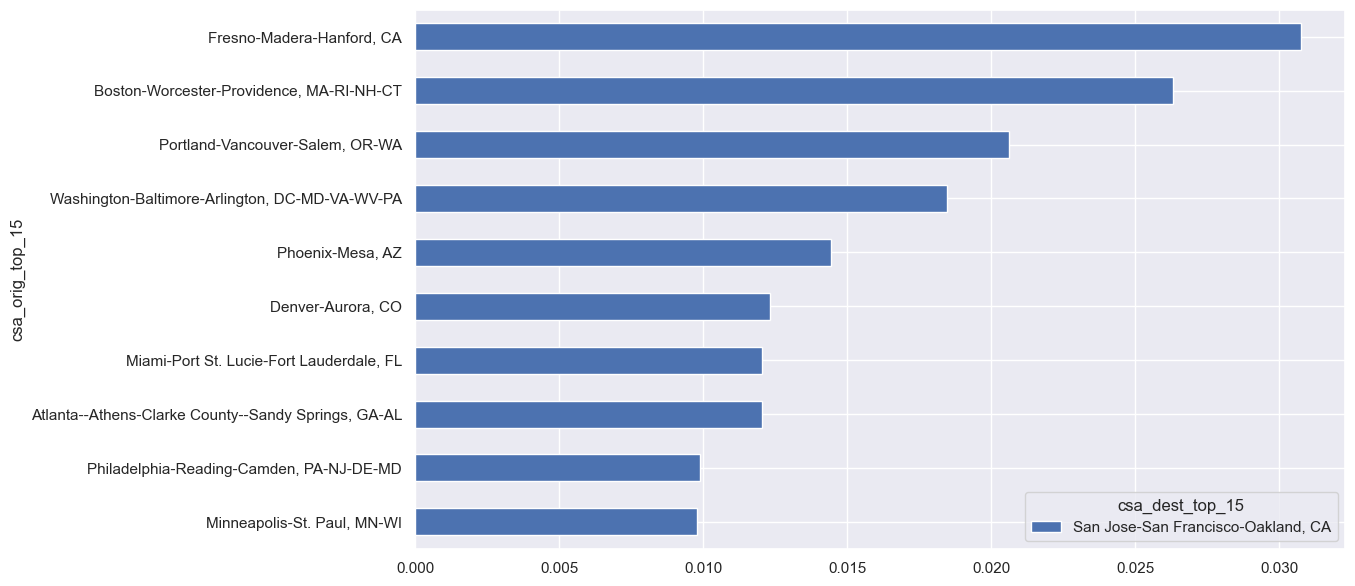

In [68]:
# Moves TO the Bay Area: top 25 origin regions 

csa_move_matrix.loc[csa_move_matrix[d_var]==BAY_AREA_CSA].set_index([d_var,o_var]).flow.groupby(level=0).apply(pct).unstack(0).sort_values(BAY_AREA_CSA).head(10).plot(kind='barh')


/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_23616/402318048.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  csa_move_matrix.loc[csa_move_matrix[o_var]==BAY_AREA_CSA].set_index([o_var,d_var]).flow.groupby(level=0).apply(pct).unstack(0).sort_values(BAY_AREA_CSA).head(10).plot(kind='barh')


<AxesSubplot: ylabel='csa_dest_top_15'>

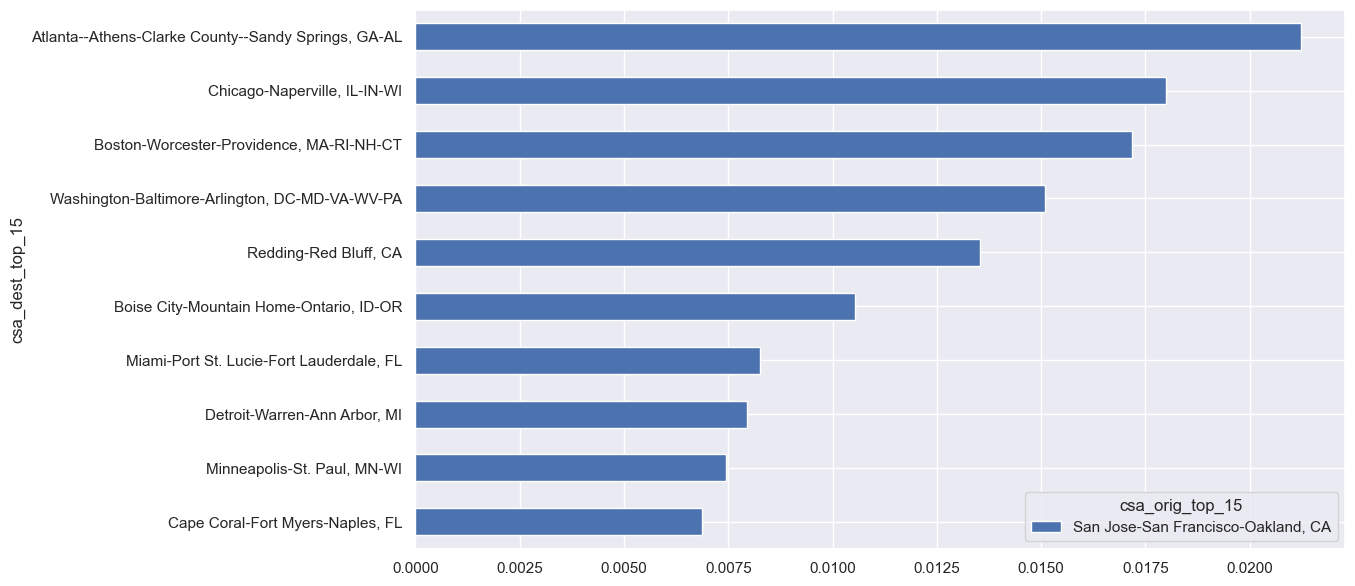

In [69]:
# Moves FROM the Bay Area: top 25 destination regions 

csa_move_matrix.loc[csa_move_matrix[o_var]==BAY_AREA_CSA].set_index([o_var,d_var]).flow.groupby(level=0).apply(pct).unstack(0).sort_values(BAY_AREA_CSA).head(10).plot(kind='barh')

In [70]:
csa_move_matrix#[csa_move_matrix.csa_dest_top_15.str.contains('New Y')]

,csa_orig_top_15,csa_dest_top_15,flow
0,"Atlanta--Athens-Clarke County--Sandy Springs, ...","Boston-Worcester-Providence, MA-RI-NH-CT",1016
1,"Atlanta--Athens-Clarke County--Sandy Springs, ...","Cape Coral-Fort Myers-Naples, FL",1840
2,"Atlanta--Athens-Clarke County--Sandy Springs, ...","Chicago-Naperville, IL-IN-WI",1736
3,"Atlanta--Athens-Clarke County--Sandy Springs, ...","Denver-Aurora, CO",1378
4,"Atlanta--Athens-Clarke County--Sandy Springs, ...","Detroit-Warren-Ann Arbor, MI",1660
...,...,...,...
243,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA","Minneapolis-St. Paul, MN-WI",831
244,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",Outside Top CSAs,92055
245,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA","Phoenix-Mesa, AZ",2063
246,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA","Sacramento-Roseville, CA",506


In [71]:
# prepare a side-by-side format

csa_move_matrix_with_net = csa_move_matrix.merge(csa_move_matrix.rename(columns={'csa_orig_top_15':'csa_dest_top_15','csa_dest_top_15':'csa_orig_top_15'}),
                                             on=['csa_orig_top_15','csa_dest_top_15']).rename(columns={'flow_x':'Flow A to B',
                                                                                        'flow_y':'Flow B to A'})
csa_move_matrix_with_net['Net Flow'] = csa_move_matrix_with_net['Flow B to A'] - csa_move_matrix_with_net['Flow A to B']
csa_move_matrix_with_net[csa_move_matrix_with_net.csa_orig_top_15=='San Jose-San Francisco-Oakland, CA']

,csa_orig_top_15,csa_dest_top_15,Flow A to B,Flow B to A,Net Flow
120,"San Jose-San Francisco-Oakland, CA","Atlanta--Athens-Clarke County--Sandy Springs, ...",5210,2631,-2579
121,"San Jose-San Francisco-Oakland, CA","Boston-Worcester-Providence, MA-RI-NH-CT",4214,5758,1544
122,"San Jose-San Francisco-Oakland, CA","Chicago-Naperville, IL-IN-WI",4416,7884,3468
123,"San Jose-San Francisco-Oakland, CA","Denver-Aurora, CO",6683,2692,-3991
124,"San Jose-San Francisco-Oakland, CA","Fresno-Madera-Hanford, CA",8534,6730,-1804
125,"San Jose-San Francisco-Oakland, CA","Los Angeles-Long Beach, CA",59709,45325,-14384
126,"San Jose-San Francisco-Oakland, CA","Miami-Port St. Lucie-Fort Lauderdale, FL",2026,2632,606
127,"San Jose-San Francisco-Oakland, CA","Minneapolis-St. Paul, MN-WI",1826,2142,316
128,"San Jose-San Francisco-Oakland, CA",Outside Top CSAs,88482,92357,3875
129,"San Jose-San Francisco-Oakland, CA","Phoenix-Mesa, AZ",6774,3160,-3614


In [72]:
PROCESSED_DATA = '/Users/aolsen/Box/Modeling and Surveys/Projects/Regional Growth Forecast Update/Estimates/PUMS'

csa_for_plot = csa_move_matrix.query(f'(csa_orig_top_15 in {top_pop[5]} & csa_dest_top_15 in {top_pop[5]}) ').sort_values('flow').set_index(['csa_orig_top_15','csa_dest_top_15']).flow
csa_for_plot.reset_index().to_csv(os.path.join(PROCESSED_DATA,'mig_puma_mig_csa.csv'))

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Atlanta--Athens-Clarke County--Sandy Springs, GA-AL'),
  Text(0, 1.5, 'Chicago-Naperville, IL-IN-WI'),
  Text(0, 2.5, 'Los Angeles-Long Beach, CA'),
  Text(0, 3.5, 'Miami-Port St. Lucie-Fort Lauderdale, FL'),
  Text(0, 4.5, 'San Jose-San Francisco-Oakland, CA')])

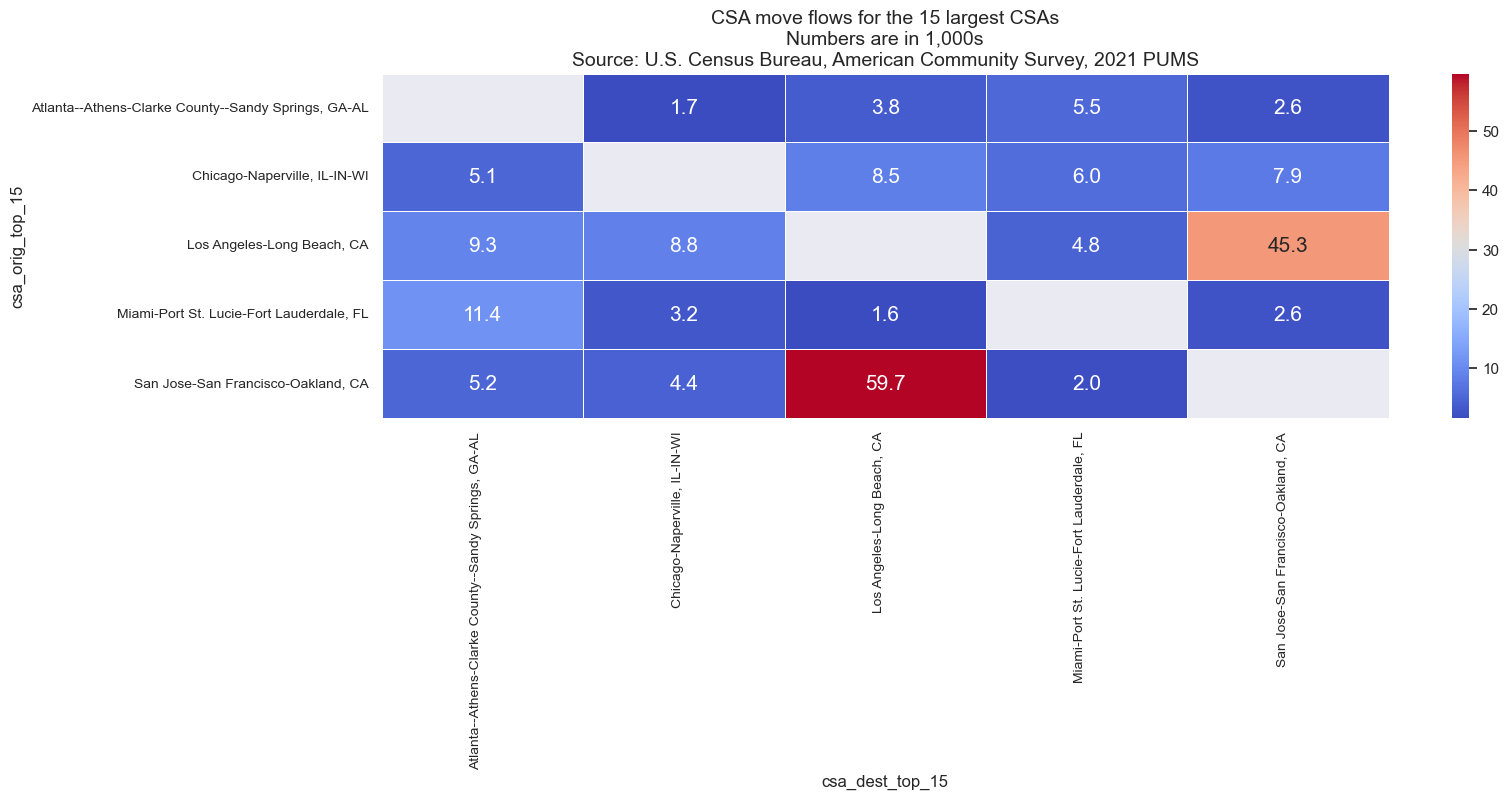

In [73]:
fig, ax = plt.subplots(figsize=[17, 8.5])
sns.heatmap(csa_for_plot.map(lambda x: x/1000).unstack(1),
            annot=True, fmt=',.1f', linewidths=.5, cmap=cm.coolwarm,
            annot_kws={'fontsize': 15})
plt.title('CSA move flows for the 15 largest CSAs\nNumbers are in 1,000s\nSource: U.S. Census Bureau, American Community Survey, 2021 PUMS', size=14)
plt.tight_layout()
plt.xticks(size=10, ha='right', rotation=90)
plt.yticks(size=10)
#wrap_labels(ax, 20)
#savefig(os.path.join(box,'COVID Density Research Proejct/Tidbits/plots/splom_heat.svg'))

#### CSA level - by age

In [74]:
# matrix where origin is not the same as destination county
csa_move_matrix_age = pers_data.loc[((pers_data.csa_orig!=pers_data.csa_dest)
                                 &(pers_data.MIG.isin([2,3])))
                                 ].groupby(['csa_orig','csa_dest','age_cat'],observed = True).PWGTP.sum().reset_index(name='flow')
csa_move_matrix_age.sort_values('flow')

,csa_orig,csa_dest,age_cat,flow
3710,"Macon-Bibb County--Warner Robins, GA","Los Angeles-Long Beach, CA",age2044,2
5237,"Orlando-Lakeland-Deltona, FL","Minneapolis-St. Paul, MN-WI",age2044,2
7186,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA","Sacramento-Roseville, CA",age4564,3
4234,"Mobile-Daphne-Fairhope, AL","Little Rock-North Little Rock, AR",age65p,3
2585,"Houston-The Woodlands, TX","Mount Pleasant-Alma, MI",age0019,4
...,...,...,...,...
5024,Not in a Combined Statistical Area,"San Jose-San Francisco-Oakland, CA",age2044,34352
6359,"San Jose-San Francisco-Oakland, CA","Los Angeles-Long Beach, CA",age2044,34555
3547,"Los Angeles-Long Beach, CA",Not in a Combined Statistical Area,age0019,37808
4917,Not in a Combined Statistical Area,"Los Angeles-Long Beach, CA",age2044,46298


In [75]:
csa_age_for_plot = csa_move_matrix_age.query(f'(csa_orig in {CSA_TOP_15} & csa_dest in {CSA_TOP_15}) ').sort_values('flow').set_index(['csa_orig','csa_dest','age_cat']).flow
csa_age_for_plot.reset_index().to_csv(os.path.join(PROCESSED_DATA,'eq04mig_puma_mig_csa_age.csv'))

NameError: name 'CSA_TOP_15' is not defined

#### CSA level - by race / ethnicity

In [ ]:
# matrix where origin is not the same as destination county
csa_move_matrix_race = pers_data.loc[((pers_data.csa_orig!=pers_data.csa_dest)
                                 &(pers_data.MIG.isin([2,3])))
                                 ].groupby(['csa_orig','csa_dest','race_ethn']).PWGTP.sum().reset_index(name='flow')
csa_move_matrix_race

In [ ]:
csa_move_matrix_race_with_net = csa_move_matrix_race.merge(csa_move_matrix_race.rename(columns={'csa_orig':'csa_dest','csa_dest':'csa_orig'}),
                                             on=['csa_orig','csa_dest','race_ethn']).rename(columns={'flow_x':'Flow A to B',
                                                                                        'flow_y':'Flow B to A'})
csa_move_matrix_race_with_net['Net Flow'] = csa_move_matrix_race_with_net['Flow A to B'] - csa_move_matrix_race_with_net['Flow B to A']
csa_move_matrix_race_with_net.set_index(['csa_orig','csa_dest','race_ethn']).unstack(2).loc['San Jose-San Francisco-Oakland, CA','Houston-The Woodlands, TX'].unstack(0).plot(kind='bar')


### Check overall flows in and out of bay area counties

#### Moved FROM Bay Area to anywhere in the US

In [ ]:
moved_from_bayarea = pers_data.loc[(pers_data.MIGSTPUMA.isin(BAY_AREA_MIGSTPUMAS))&
                                  (pers_data.stcounty_dest_bayarea==False)].groupby(['csa_orig','csa_dest']).PWGTP.sum()
moved_from_bayarea.sort_values(ascending=False).head(10)

In [ ]:
bayarea_exit_totals = pers_data.loc[(pers_data.MIGSTPUMA.isin(BAY_AREA_MIGSTPUMAS))&
                                  (pers_data.stcounty_dest_bayarea==False)].groupby(['csa_orig','csa_dest']).PWGTP.sum()
bayarea_exit_totals

#### Moved TO the Bay Area FROM anywhere in the US

In [ ]:
moved_to_bayarea = pers_data.loc[(pers_data.stcounty_dest.isin(bayareafips_full)) & (pers_data.MIGSP)
                                 & (pers_data.stcounty_orig_bayarea == False)].groupby(['csa_orig', 'csa_dest']).PWGTP.sum().sort_values().tail(20)
moved_to_bayarea.sort_values(ascending=False).head(10)

In [ ]:
bayarea_newcomers_total = pers_data.loc[(pers_data.stcounty_dest.isin(bayareafips_full)) & (pers_data.MIGSP)
              & (pers_data.stcounty_orig_bayarea == False)].groupby(['csa_dest']).PWGTP.sum()
bayarea_newcomers_total

#### Moved WITHIN the Bay Area but to a different county

In [99]:
moved_within_bayarea = pers_data.loc[ 
                                 (pers_data.stcounty_dest_bayarea)
                                     & (pers_data.stcounty_orig_bayarea)
&(pers_data.stcounty_dest!=pers_data.stcounty_orig)].groupby(['county_orig', 'county_dest']).PWGTP.sum().sort_values()


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'Alameda County (CA)'),
  Text(0, 1.5, 'Contra Costa County (CA)'),
  Text(0, 2.5, 'Marin County (CA)'),
  Text(0, 3.5, 'Napa County (CA)'),
  Text(0, 4.5, 'San Francisco County (CA)'),
  Text(0, 5.5, 'San Mateo County (CA)'),
  Text(0, 6.5, 'Santa Clara County (CA)'),
  Text(0, 7.5, 'Solano County (CA)'),
  Text(0, 8.5, 'Sonoma County (CA)')])

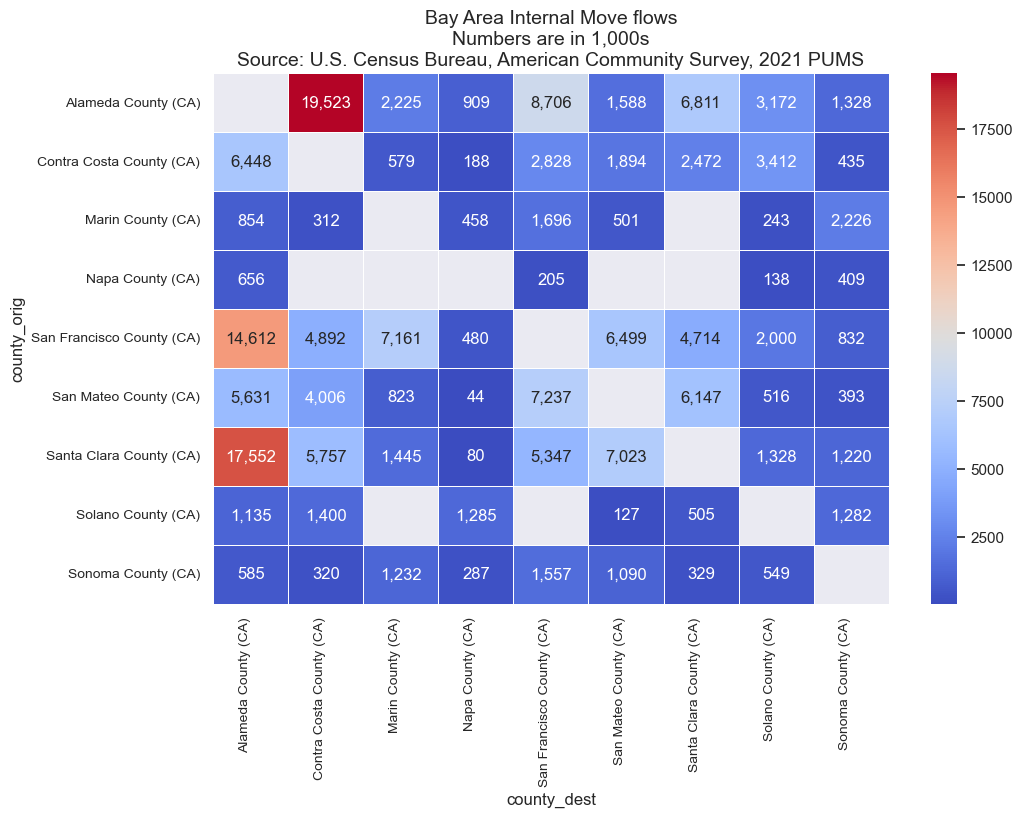

In [107]:
fig, ax = plt.subplots(figsize=[11, 8.5])
sns.heatmap(moved_within_bayarea.unstack(1),
            annot=True, fmt=',.0f', linewidths=.5, cmap=cm.coolwarm,
            annot_kws={'fontsize': 12})
plt.title('Bay Area Internal Move flows\nNumbers are in 1,000s\nSource: U.S. Census Bureau, American Community Survey, 2021 PUMS', size=14)
plt.tight_layout()
plt.xticks(size=10, ha='right', rotation=90)
plt.yticks(size=10)
#wrap_labels(ax, 20)
#savefig(os.path.join(box,'COVID Density Research Proejct/Tidbits/plots/splom_heat.svg'))

In [118]:
for i, row in moved_within_bayarea.groupby(level=0):
    print(i)


Alameda County (CA)
Contra Costa County (CA)
Marin County (CA)
Napa County (CA)
San Francisco County (CA)
San Mateo County (CA)
Santa Clara County (CA)
Solano County (CA)
Sonoma County (CA)


/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_23616/1395307046.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  moved_within_bayarea.sum(level=1)


county_dest
Napa County (CA)              3731
San Mateo County (CA)        18722
Solano County (CA)           11358
San Francisco County (CA)    27576
Contra Costa County (CA)     36210
Santa Clara County (CA)      20978
Sonoma County (CA)            8125
Marin County (CA)            13465
Alameda County (CA)          47473
Name: PWGTP, dtype: int64

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_23616/3386451513.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  bayarea_flows = pd.concat([moved_within_bayarea.sum(level=0),
/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_23616/3386451513.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  moved_within_bayarea.sum(level=1)],keys=['outbound','inbound'],names=['direction']).unstack(0)


Text(0.5, 0.98, 'Net flow direction, Bay Area Counties\nUniverse: Bay Area Movers to a Different Bay Area Count\nSource: US Census Bureau, PUMS 2021')

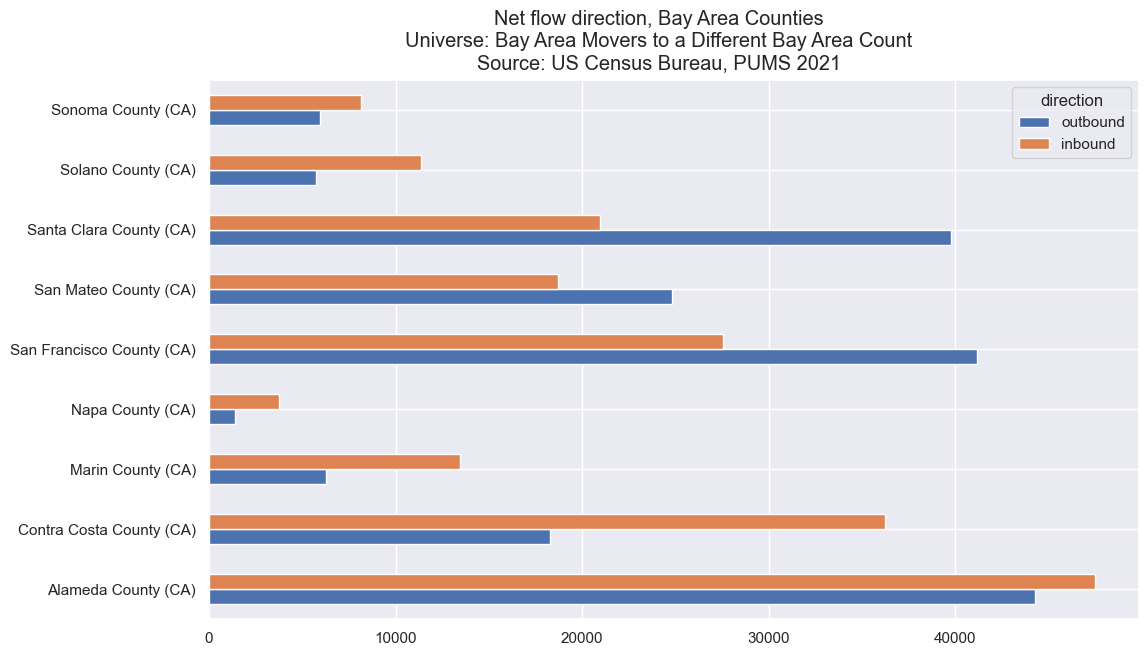

In [130]:
# collapse all flows
bayarea_flows = pd.concat([moved_within_bayarea.sum(level=0),
          moved_within_bayarea.sum(level=1)],keys=['outbound','inbound'],names=['direction']).unstack(0)
bayarea_flows.plot(kind='barh')
plt.suptitle('Net flow direction, Bay Area Counties\nUniverse: Bay Area Movers to a Different Bay Area Count\nSource: US Census Bureau, PUMS 2021')

## Place of Work tabulation

In [ ]:
# 11-wfh
pers_data[pers_data['stcounty_pow']=='06075'].groupby(['JWTRNS']).PWGTP.sum()/pers_data[pers_data['stcounty_pow']=='06075'].groupby(['JWTRNS']).PWGTP.sum().sum()

In [ ]:
(pers_data.loc[(pers_data['stcounty_pow']=='06075')
              &(pers_data.JWTRNS!=11)].groupby(['JWTRNS']).PWGTP.sum()/pers_data.loc[(pers_data['stcounty_pow']=='06075')
              &(pers_data.JWTRNS!=11)].groupby(['JWTRNS']).PWGTP.sum().sum()).plot(kind='bar')

<AxesSubplot: xlabel='JWTRNS'>

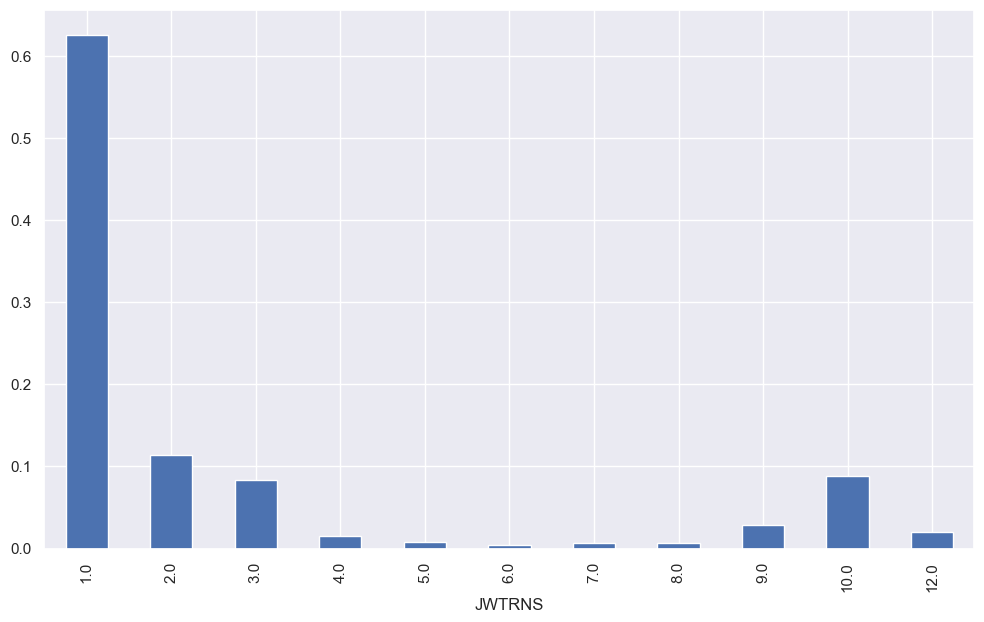

In [82]:
(pers_data.loc[(pers_data['stcounty_pow']=='06075')
              &(pers_data.JWTRNS!=11)].groupby(['JWTRNS']).PWGTP.sum()/pers_data.loc[(pers_data['stcounty_pow']=='06075')
              &(pers_data.JWTRNS!=11)].groupby(['JWTRNS']).PWGTP.sum().sum()).plot(kind='bar')

In [78]:
pers_data.loc[(pers_data['stcounty_pow']=='06075')
              &(pers_data.JWTRNS!=11)].groupby(['JWTRNS']).PWGTP.sum()

JWTRNS
1.0     227903
2.0      41407
3.0      30349
4.0       5471
5.0       2985
6.0       1559
7.0       2613
8.0       2505
9.0      10649
10.0     32108
12.0      7215
Name: PWGTP, dtype: int64

In [109]:
pers_data.query('POWPUMA.notna() & ST==6 & JWTRNS==11 & stcounty_dest!=stcounty_pow').groupby(['stcounty_dest','county_dest','stcounty_dest_bayarea','stcounty_pow','POWSP','POWPUMA','JWTRNS']).PWGTP.sum().reset_index()


,stcounty_dest,county_dest,stcounty_dest_bayarea,stcounty_pow,POWSP,POWPUMA,JWTRNS,PWGTP
0,06027,Inyo County (CA),False,06109,6.0,300.0,11.0,11450
1,06105,Trinity County (CA),False,06103,6.0,1100.0,11.0,4008
2,06115,Yuba County (CA),False,06101,6.0,10100.0,11.0,4753


In [83]:
pers_data.query('POWPUMA.notna() & JWTRNS==11 & stcounty_dest!=stcounty_pow').groupby(['stcounty_dest','county_dest','stcounty_dest_bayarea','stcounty_pow','POWSP','POWPUMA','JWTRNS']).PWGTP.sum().reset_index()


,stcounty_dest,county_dest,stcounty_dest_bayarea,stcounty_pow,POWSP,POWPUMA,JWTRNS,PWGTP
0,01005,Barbour County (AL),False,01113,1.0,2400.0,11.0,1913
1,01025,Clarke County (AL),False,01053,1.0,2200.0,11.0,1109
2,01039,Covington County (AL),False,01031,1.0,2300.0,11.0,1204
3,01071,Jackson County (AL),False,01049,1.0,400.0,11.0,4003
4,01079,Lawrence County (AL),False,01103,1.0,600.0,11.0,4013
...,...,...,...,...,...,...,...,...
184,28103,Noxubee County (MS),False,28087,28.0,600.0,11.0,3114
185,28111,Perry County (MS),False,28035,28.0,1800.0,11.0,3606
186,28115,Pontotoc County (MS),False,28081,28.0,500.0,11.0,2217
187,28153,Wayne County (MS),False,28067,28.0,1700.0,11.0,1941
